<div style="text-align: center;">
  <img src="../Images/UTA_logo.png" alt="UTA LOGO" height="133" width="500">
</div>

# Project 1: Fixed Route Traffic Stop Predictor
***

##### Phase 1: Data Cleaning and Wrangling


In this notebook, we will focus primarily on cleaning the data available from the _UTA Open Data_ Database.  We will ensure to the best of our ability that the data is:
- Complete
- Consistant
- & Accurate (where reasonable possible to do so)


This project series is to function as a proof of concept pursuant to our desired outcome: a _Dynamic Routing Generative AI_ for use largely for the benefit of the planning department but also could be used for quick rerouting and predicting better detours during construction periods.


In [3]:
# Import Modules
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Extra modules as needed
import math as mt

In [4]:
# Specific Notebook Functions Here:
def checkList(lst):
    ele= lst[0]
    chk= all(i != i for i in lst)
    return chk, ele

In [5]:
# Import Data .csv files into Pandas DataFrames
bus_stop_ridership_df = pd.read_csv("../Data_RAW/bus_stop_ridership_table.csv", low_memory=False)
uta_mode_level_boardings_weekday_averages_df = pd.read_csv("../Data_RAW/uta_mode_level_boardings_weekday_averages.csv")
uta_route_level_ridership_monthly_counts_df = pd.read_csv("../Data_RAW/uta_route_level_ridership_table__monthly_counts.csv")
uta_routes_and_most_recent_ridership_df = pd.read_csv("../Data_RAW/uta_routes_and_most_recent_ridership.csv")

In [6]:
bus_stop_ridership_df.head()

,objectid,servicetype,month_,year_,stopabbr,stopname,city,county,avgboardings,avgalight,routes
0,1,SAT,January,2020.0,135009,Constitution Blvd @ 3662 S,West Valley City,Salt Lake,0,0.269040524,"39,227"
1,2,WKD,January,2020.0,101088,Gentile St @ 357 E (Layton),Layton,Davis,13.53700138,11.23065101,"628,470"
2,3,WKD,January,2020.0,629172,Harrison Blvd @ 4605 S (Ogden),Ogden,Weber,2.104692794,9.510210858,NaN
3,4,SUN,January,2020.0,135009,Constitution Blvd @ 3662 S,West Valley City,Salt Lake,0,0,"39,227"
4,5,WKD,January,2020.0,135009,Constitution Blvd @ 3662 S,West Valley City,Salt Lake,1.195848178,1.003590091,"39,227"


In [7]:
bus_stop_ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634393 entries, 0 to 634392
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   objectid      634393 non-null  int64  
 1   servicetype   634391 non-null  object 
 2   month_        634391 non-null  object 
 3   year_         634391 non-null  float64
 4   stopabbr      634391 non-null  object 
 5   stopname      634391 non-null  object 
 6   city          634248 non-null  object 
 7   county        634379 non-null  object 
 8   avgboardings  634391 non-null  object 
 9   avgalight     634391 non-null  object 
 10  routes        630104 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 53.2+ MB


In [8]:
uta_mode_level_boardings_weekday_averages_df.head()

,objectid,objectid_1,uta_mode,month_,wkd2017,wkd2018,wkd2019,wkd2020,wkd2021,wkd2022,wkd2023,wkd2024,wkd2025
0,9,9,Systemwide Ridership,September,171252.0,177946.0,174634.0,70866.0,101143.0,124206,138883,NaN,NaN
1,10,10,Systemwide Ridership,October,160425.0,162238.0,164327.0,67425.0,93835.0,117089,132174,NaN,NaN
2,11,11,Systemwide Ridership,November,163537.0,163148.0,159709.0,63213.0,95564.0,111165,128066,NaN,NaN
3,12,12,Systemwide Ridership,December,147735.0,142484.0,142114.0,60100.0,87840.0,97366,115264,NaN,NaN
4,21,21,Commuter Rail,September,19155.0,21800.0,21428.0,5383.0,10262.0,14208,15832,NaN,NaN


In [9]:
uta_mode_level_boardings_weekday_averages_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180 entries, 0 to 179
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   objectid    180 non-null    int64  
 1   objectid_1  180 non-null    int64  
 2   uta_mode    180 non-null    object 
 3   month_      180 non-null    object 
 4   wkd2017     156 non-null    float64
 5   wkd2018     161 non-null    float64
 6   wkd2019     168 non-null    float64
 7   wkd2020     168 non-null    float64
 8   wkd2021     173 non-null    float64
 9   wkd2022     180 non-null    int64  
 10  wkd2023     180 non-null    int64  
 11  wkd2024     120 non-null    float64
 12  wkd2025     0 non-null      float64
dtypes: float64(7), int64(4), object(2)
memory usage: 18.4+ KB


In [10]:
uta_route_level_ridership_monthly_counts_df.head()

,objectid,mode,lineabbr,month_,year_,servicetype,avgboardings,city,county
0,1,Fixed Route Bus - Regular,1,February,2024,SAT,1190.376667,Salt Lake City,Salt Lake
1,2,Fixed Route Bus - Regular,1,January,2024,SUN,532.083333,Salt Lake City,Salt Lake
2,3,Fixed Route Bus - Regular,1,February,2024,WKD,2677.471900,Salt Lake City,Salt Lake
3,4,Fixed Route Bus - Regular,1,February,2024,SUN,622.216667,Salt Lake City,Salt Lake
4,5,Fixed Route Bus - Regular,1,January,2024,SAT,1031.400000,Salt Lake City,Salt Lake


In [11]:
uta_route_level_ridership_monthly_counts_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18234 entries, 0 to 18233
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   objectid      18234 non-null  int64  
 1   mode          18234 non-null  object 
 2   lineabbr      18234 non-null  object 
 3   month_        18234 non-null  object 
 4   year_         18234 non-null  int64  
 5   servicetype   18234 non-null  object 
 6   avgboardings  18234 non-null  float64
 7   city          18234 non-null  object 
 8   county        18228 non-null  object 
dtypes: float64(1), int64(2), object(6)
memory usage: 1.3+ MB


In [12]:
uta_routes_and_most_recent_ridership_df.head()

,fid,lineabbr,linename,frequency,routetype,city,avgbrd,county,lineabbr1,shape__len,st_length_shape_
0,1,1,SOUTH TEMPLE,15,Frequent,Salt Lake City,2665.0,Salt Lake,1,0.216543,NaN
1,11,47,4700 SOUTH,30,Regular,"Taylorsville, Murray, West Valley City",1468.0,Salt Lake,47,0.289048,NaN
2,3,4,400 SOUTH,30,Regular,"Salt Lake City, Millcreek",1127.0,Salt Lake,4,0.289614,NaN
3,4,9,900 SOUTH,15,Frequent,Salt Lake City,1992.0,Salt Lake,9,0.208646,NaN
4,72,F202,SANDY PARKWAY FLEX,30,Regular,"Midvale, Sandy, Murray, South Jordan",193.0,Salt Lake,0,0.102216,NaN


In [13]:
uta_routes_and_most_recent_ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   fid               81 non-null     int64  
 1   lineabbr          81 non-null     object 
 2   linename          81 non-null     object 
 3   frequency         81 non-null     object 
 4   routetype         81 non-null     object 
 5   city              81 non-null     object 
 6   avgbrd            80 non-null     float64
 7   county            81 non-null     object 
 8   lineabbr1         81 non-null     int64  
 9   shape__len        78 non-null     float64
 10  st_length_shape_  0 non-null      float64
dtypes: float64(3), int64(2), object(6)
memory usage: 7.1+ KB


Under the circumstances this data has been aggregated in some form already for the benefit of the average data user/businessman's need and desired metrics. Due to this generalization, we will not be able to create a proof of concept route prediction time series model sadly as we lack arrival and departure times as well as approx. value of clients boarding and alighting buses on a per stop basis.  Also there are a number of missing values which need to be addressed so a quick cleaning shall commense followed by some EDA to determine what we might meaningfully do with this opensource data.
***

In [14]:
# Drop rows with missing data in column: 'year_'
bus_stop_ridership_df = bus_stop_ridership_df.dropna(subset=['year_'])

# Replace missing values with "" in columns: 'servicetype', 'month_' and 4 other columns
bus_stop_ridership_df = bus_stop_ridership_df.fillna({'servicetype': "", 'month_': "", 'stopname': "", 'city': "", 'county': "", "routes": ""})
for i, col in bus_stop_ridership_df[bus_stop_ridership_df['routes'] == ""].iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = np.NaN

# Change column type to int16 for column: 'year_'
bus_stop_ridership_df = bus_stop_ridership_df.astype({'year_': 'int16'})

# Convert text to uppercase in columns: 'month_', 'stopname' and 2 other columns
bus_stop_ridership_df['month_'] = bus_stop_ridership_df['month_'].str.upper()
bus_stop_ridership_df['stopname'] = bus_stop_ridership_df['stopname'].str.upper()
bus_stop_ridership_df['city'] = bus_stop_ridership_df['city'].str.upper()
bus_stop_ridership_df['county'] = bus_stop_ridership_df['county'].str.upper()

# correct categories in column: 'city' and fill missing values in columns: 'city', 'county'
for i, col in bus_stop_ridership_df[bus_stop_ridership_df['city'] == 'SOUTH SALT LAKE CITY'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'SOUTH SALT LAKE'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == "36TH ST / BRINKER (EB)"].iterrows():
    bus_stop_ridership_df.loc[i, 'county'] = 'WEBER'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == "100 W LAYTON PARKWAY (EB)"].iterrows():
    bus_stop_ridership_df.loc[i, 'county'] = 'DAVIS'

for i, col in bus_stop_ridership_df[(bus_stop_ridership_df['stopname'] == '400 S / CHEYENNE ST (EB)') | (bus_stop_ridership_df['stopname'] == '400 S @ 918 W') | (bus_stop_ridership_df['stopname'] == '400 S @ 1049 W') | (bus_stop_ridership_df['stopname'] == 'FOOTHILL DR @ 1707 S')].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'SALT LAKE CITY'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == '3030 W / 3500 S (SB)'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'WEST VALLEY CITY'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == '300 W / 2100 S (NB)'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'SOUTH SALT LAKE'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == '4000 W / 7800 S (SB)'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'WEST JORDAN'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == '900 E / 4200 S (NB)'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'MILLCREEK'

for i, col in bus_stop_ridership_df[(bus_stop_ridership_df['stopname'] == '900 E / 450 N (NB)') | (bus_stop_ridership_df['stopname'] == 'FREEDOM BLVD / 1800 N (SB)')].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'PROVO'

for i, col in bus_stop_ridership_df[bus_stop_ridership_df['stopname'] == 'ORCHARD DR @ 3562 S'].iterrows():
    bus_stop_ridership_df.loc[i, 'city'] = 'NORTH SALT LAKE'

# Fill missing values in column: 'routes'

# Change column type to category for columns: 'month_', 'year_' and 2 other columns
bus_stop_ridership_df = bus_stop_ridership_df.astype({'month_': 'category', 'year_': 'category', 'city': 'category', 'county': 'category'})

# Change column type to string for columns: 'avgboardings', 'avgalight'
bus_stop_ridership_df = bus_stop_ridership_df.astype({'avgboardings': 'string', 'avgalight': 'string'})

# Clear all values in column: 'avgboardings' which contain a ','
temp_df = bus_stop_ridership_df[bus_stop_ridership_df['avgboardings'].str.contains(",", regex=False, na=False)]

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'avgboardings'] = col['avgboardings'].split(',')[0]

# Clear all values in column: 'avgalight' which contain a ','
temp_df = bus_stop_ridership_df[bus_stop_ridership_df['avgalight'].str.contains(",", regex=False, na=False)]

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'avgalight'] = col['avgalight'].split(',')[0]

# Change column type to float16 for columns: 'avgboardings', 'avgalight'
bus_stop_ridership_df = bus_stop_ridership_df.astype({'avgboardings': 'float16', 'avgalight': 'float16'})

# Round columns 'avgboardings', 'avgalight' (Number of decimals: 0)
bus_stop_ridership_df = bus_stop_ridership_df.round({'avgboardings': 0, 'avgalight': 0})

# Change column type to int8 for columns: 'avgboardings', 'avgalight'
bus_stop_ridership_df = bus_stop_ridership_df.astype({'avgboardings': 'int8', 'avgalight': 'int8'})

# Change negative values in columns: 'avgboardings', 'avgalight' to 0
temp_df = bus_stop_ridership_df[bus_stop_ridership_df['avgboardings'] < 0]

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'avgboardings'] = 0

temp_df = bus_stop_ridership_df[bus_stop_ridership_df['avgalight'] < 0]

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'avgalight'] = 0

# bfill() column: 'routes' by column: 'stopabbr and store unresolvable stopabbr in 'unsolvable_stops' list
stops_tup = tuple(bus_stop_ridership_df[bus_stop_ridership_df['routes'].isna() == True]['stopabbr'].unique())
unsolvable_stops = []

for stop in stops_tup:
    temp_df = bus_stop_ridership_df[bus_stop_ridership_df['stopabbr'] == stop]
    same, val = checkList(list(temp_df['routes'].values))
    if same == True and mt.isnan(val) == True:
        unsolvable_stops.append(stop)
        continue
    else:
        temp_df = temp_df.fillna({'routes': temp_df['routes'].bfill()})
        for i, col in temp_df.iterrows():
            bus_stop_ridership_df.loc[i, 'routes'] = temp_df.loc[i, 'routes']

# Fill remaining NaN on column: 'routes'
temp_df = bus_stop_ridership_df[(bus_stop_ridership_df['stopabbr'] == unsolvable_stops[0]) |
                      (bus_stop_ridership_df['stopabbr'] == unsolvable_stops[1]) |
                      (bus_stop_ridership_df['stopabbr'] == unsolvable_stops[8])
                      ] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '4'

temp_df = bus_stop_ridership_df[(bus_stop_ridership_df['stopabbr'] == unsolvable_stops[6]) |
                      (bus_stop_ridership_df['stopabbr'] == unsolvable_stops[7]) |
                      (bus_stop_ridership_df['stopabbr'] == unsolvable_stops[10])
                      ] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '470'


temp_df = bus_stop_ridership_df[bus_stop_ridership_df['stopabbr'] == unsolvable_stops[2]] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '72, 972'

temp_df = bus_stop_ridership_df[bus_stop_ridership_df['stopabbr'] == unsolvable_stops[4]] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '209'

temp_df = bus_stop_ridership_df[bus_stop_ridership_df['stopabbr'] == unsolvable_stops[5]] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '994'

temp_df = bus_stop_ridership_df[bus_stop_ridership_df['stopabbr'] == unsolvable_stops[9]] 

for i, col in temp_df.iterrows():
    bus_stop_ridership_df.loc[i, 'routes'] = '640'

bus_stop_ridership_df = bus_stop_ridership_df.dropna(subset=['routes'])

# Finally set columns: 'servicetype', 'stopabbr', 'stopname', & 'routes' as categories
bus_stop_ridership_df = bus_stop_ridership_df.astype({'stopabbr': 'category', 'stopname': 'category', 'servicetype': 'category', 'routes': 'category'})

In [15]:
bus_stop_ridership_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 633897 entries, 0 to 634392
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   objectid      633897 non-null  int64   
 1   servicetype   633897 non-null  category
 2   month_        633897 non-null  category
 3   year_         633897 non-null  category
 4   stopabbr      633897 non-null  category
 5   stopname      633897 non-null  category
 6   city          633897 non-null  category
 7   county        633897 non-null  category
 8   avgboardings  633897 non-null  int8    
 9   avgalight     633897 non-null  int8    
 10  routes        633897 non-null  category
dtypes: category(8), int64(1), int8(2)
memory usage: 17.9 MB


In [16]:
bus_stop_ridership_df.tail()

,objectid,servicetype,month_,year_,stopabbr,stopname,city,county,avgboardings,avgalight,routes
634388,710438,WKD,AUGUST,2024,S177003,IRON BLOSAM,SNOWBIRD,SALT LAKE,2,4,994
634389,710439,WKD,AUGUST,2024,S177006,PERUVIAN LODGE (UP),ALTA,SALT LAKE,0,0,994
634390,710440,WKD,AUGUST,2024,S177007,GOLDMINER'S DAUGHTER LODGE,ALTA,SALT LAKE,1,2,994
634391,710441,WKD,AUGUST,2024,S177013,CREEKSIDE (UP),SNOWBIRD,SALT LAKE,0,0,994
634392,710442,WKD,AUGUST,2024,S177014,CREEKSIDE (DOWN),SNOWBIRD,SALT LAKE,0,0,994


In [23]:
UTA_Mode_Level_Boardings_Map = gpd.read_file('../Data_RAW/uta_mode_level_boardings_weekday_averages/UTA_Mode_Level_Boardings.shp')
UTA_Route_Level_Boardings_Map = gpd.read_file('../Data_RAW/uta_route_level_ridership_table__monthly_counts/UTA_ROUTE_LEVEL_BOARDINGS.shp')
UTA_Routes_and_Most_Recent_Ridership_Map = gpd.read_file('../Data_RAW/uta_routes_and_most_recent_ridership/UTA_ROUTES.shp')
UTA_Stops_and_Most_Recent_Ridership_Map = gpd.read_file('../Data_RAW/uta_stops_and_most_recent_ridership/UTA_STOPS.shp')

In [24]:
UTA_Mode_Level_Boardings_Map.head()

,objectid,objectid_1,uta_mode,month_,wkd2017,wkd2018,wkd2019,wkd2020,wkd2021,wkd2022,wkd2023,wkd2024,wkd2025,geometry
0,9,9,Systemwide Ridership,September,171252,177946,174634,70866,101143,124206,138883,0,0,None
1,10,10,Systemwide Ridership,October,160425,162238,164327,67425,93835,117089,132174,0,0,None
2,11,11,Systemwide Ridership,November,163537,163148,159709,63213,95564,111165,128066,0,0,None
3,12,12,Systemwide Ridership,December,147735,142484,142114,60100,87840,97366,115264,0,0,None
4,21,21,Commuter Rail,September,19155,21800,21428,5383,10262,14208,15832,0,0,None


In [25]:
UTA_Route_Level_Boardings_Map.head()

,objectid,mode,lineabbr,month_,year_,servicetyp,avgboardin,city,county,geometry
0,1,Fixed Route Bus - Regular,1,February,2024,SAT,1190.376667,Salt Lake City,Salt Lake,None
1,2,Fixed Route Bus - Regular,1,January,2024,SUN,532.083333,Salt Lake City,Salt Lake,None
2,3,Fixed Route Bus - Regular,1,February,2024,WKD,2677.471900,Salt Lake City,Salt Lake,None
3,4,Fixed Route Bus - Regular,1,February,2024,SUN,622.216667,Salt Lake City,Salt Lake,None
4,5,Fixed Route Bus - Regular,1,January,2024,SAT,1031.400000,Salt Lake City,Salt Lake,None


In [26]:
UTA_Routes_and_Most_Recent_Ridership_Map.head()

,fid_,lineabbr,linename,frequency,routetype,city,avgbrd,county,lineabbr1,shape__len,st_length_,geometry
0,1,1,SOUTH TEMPLE,15,Frequent,Salt Lake City,2665,Salt Lake,1,0.216543,26679.449663,"MULTILINESTRING ((-12452649.084 4978381.608, -..."
1,11,47,4700 SOUTH,30,Regular,"Taylorsville, Murray, West Valley City",1468,Salt Lake,47,0.289048,43183.052351,"MULTILINESTRING ((-12465717.992 4963429.812, -..."
2,3,4,400 SOUTH,30,Regular,"Salt Lake City, Millcreek",1127,Salt Lake,4,0.289614,36008.992674,"MULTILINESTRING ((-12450566.296 4976785.316, -..."
3,4,9,900 SOUTH,15,Frequent,Salt Lake City,1992,Salt Lake,9,0.208646,25795.991148,"MULTILINESTRING ((-12450515.089 4978618.259, -..."
4,72,F202,SANDY PARKWAY FLEX,30,Regular,"Midvale, Sandy, Murray, South Jordan",193,Salt Lake,0,0.102216,13887.502759,"MULTILINESTRING ((-12457121.901 4952052.095, -..."


In [27]:
UTA_Stops_and_Most_Recent_Ridership_Map.head()

,fid_,stopabbr,stopname,city,county,stopabbr_j,uta_stopid,latitude,longitude,avgboard,avgalight,route,mode,zipcode,avgboard2,avgalight2,geometry
0,156,101279,500 S / VA Hospital (WB),Salt Lake City,Salt Lake,101279,101279,40.758693,-111.842817,18,29,4,Bus,84112,18.22,28.70,POINT (-111.84282 40.75869)
1,158,101286,900 E / 100 S (NB),Salt Lake City,Salt Lake,101286,101286,40.767730,-111.865239,6,27,209,Bus,84102,5.76,26.64,POINT (-111.86524 40.76773)
2,130,101239,6200 S @ 4485 W,West Jordan,Salt Lake,101239,101239,40.638501,-111.997841,4,0,62,Bus,84118,3.50,0.00,POINT (-111.99784 40.6385)
3,163,101294,Greenwood Ter / Sunnyside Ave (NB),Salt Lake City,Salt Lake,101294,101294,40.750637,-111.845259,9,16,"17, 9",Bus,84105,9.06,15.71,POINT (-111.84526 40.75064)
4,167,101299,1700 E @ 1797 S,Salt Lake City,Salt Lake,101299,101299,40.731274,-111.842216,2,0,223,Bus,84108,1.75,0.10,POINT (-111.84222 40.73127)


<Axes: >

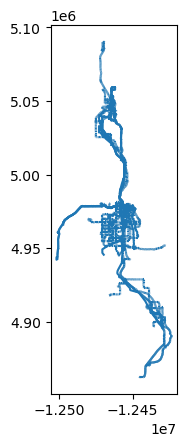

In [28]:
UTA_Routes_and_Most_Recent_Ridership_Map.plot()

<Axes: >

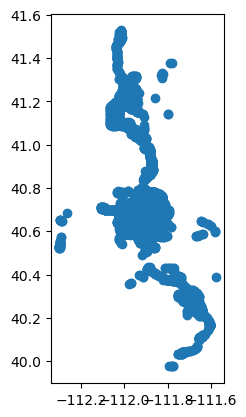

In [29]:
UTA_Stops_and_Most_Recent_Ridership_Map.plot()